# Age Classification Using Support Vector Machine
## Pipeline:
- Load data from train/val/test split
    - Resize data to uniform shape (150,150)
    - Normalise values to between 0 and 1 unsigned 8bit integers
    - Convert to grescale
    - Equalise histograms
- Extract features from data
    - LBP
    - Edges
    - HoG
- Train SVM on image features
    - X_train will contain the feature vectors of the images
    - y_train will contain the ages of each image
- When classifying a new image we:
    - Preprocess (reshape, greyscale, equalise histograms)
    - Extract features (LBP, edges, HoG)
    - Input the feature vector X_new to the SVM



In [1]:
# Imports
import pandas as pd
import numpy as np
import os
import cv2
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from skimage.exposure import rescale_intensity
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import svm 
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import accuracy_score, log_loss, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Load the data

### First load the data about the images and split it into for labels > or < 25

In [41]:
# Paths
train_csv_path = '/Users/sambeattie/Documents/Level4Project/appa-real-release/gt_avg_train.csv'
# train_image_dir = '/Users/sambeattie/Documents/Level4Project/appa-real-release/train'
train_image_dir = '/Users/sambeattie/Documents/Level4Project/appa-real-release/cropped_train'

val_csv_path = '/Users/sambeattie/Documents/Level4Project/appa-real-release/gt_avg_valid.csv'
# val_image_dir = '/Users/sambeattie/Documents/Level4Project/appa-real-release/valid'
val_image_dir = '/Users/sambeattie/Documents/Level4Project/appa-real-release/cropped_valid'

test_csv_path = '/Users/sambeattie/Documents/Level4Project/appa-real-release/gt_avg_test.csv'
# test_image_dir = '/Users/sambeattie/Documents/Level4Project/appa-real-release/test'
test_image_dir = '/Users/sambeattie/Documents/Level4Project/appa-real-release/cropped_test'

# Load CSV and create labels
# 0 if under 25, 1 if over 25
age_type = 'real_age'  # real_age / apparent_age_avg

df_train = pd.read_csv(train_csv_path)
# print(df['file_name'][:10])
# print(df['label'][:10])
df_val = pd.read_csv(val_csv_path)

df_test = pd.read_csv(test_csv_path)


In [7]:
def filter_existing_files(df, image_dir, extension="_face.jpg"):
    # Removes entries in the dataframe where the image has been removed from dataset
    df['exists'] = df['file_name'].apply(lambda name: os.path.exists(os.path.join(image_dir, name + extension)))
    return df[df['exists']].drop(columns=['exists'])

# Filter the DataFrames
df_train = filter_existing_files(df_train, train_image_dir)
df_val = filter_existing_files(df_val, val_image_dir)
df_test = filter_existing_files(df_test, test_image_dir)

In [8]:
df_train['label'] = df_train[age_type].apply(lambda x: 1 if x > 25 else 0)

df_val['label'] = df_val[age_type].apply(lambda x: 1 if x > 25 else 0)

df_test['label'] = df_test[age_type].apply(lambda x: 1 if x > 25 else 0)

In [9]:
def resize_image(image, shape=(150,150)):
    h, w = image.shape[:2]
    img_dim = h*w
    target_dim = shape[0] * shape[1]
    
    if img_dim < target_dim:
        # Upsample
        interpolation_method = cv2.INTER_CUBIC  # or cv2.INTER_LINEAR        
    else:
        # Downsample
        interpolation_method = cv2.INTER_LANCZOS4  # or cv2.INTER_CUBIC

    resized_image = cv2.resize(image, shape, interpolation=interpolation_method)
    return resized_image

In [10]:
# Stratified batch generator to ensure even split of classes (under 25 and over 25)
# Loads and preprocesses images
def stratified_batch_generator(df, image_dir, batch_size=32, img_size=(150, 150)):
    while True:
        n_per_class = batch_size // 2 

        # Sample half the batch size from each class
        batch_under_25 = df[df['label'] == 0].sample(n=n_per_class, replace=False)
        batch_over_25 = df[df['label'] == 1].sample(n=n_per_class, replace=False)

        # Combine the samples
        batch_df = pd.concat([batch_under_25, batch_over_25])

        batch_images, batch_labels = [], []
        resolution= []
        
        for idx, (_, row) in enumerate(batch_df.iterrows()):

            # Calculate progress as percentage
            progress = (idx + 1) / len(batch_df) * 100

            # Use modulo to print at milestones: 25%, 50%, 75%, 100%
            # if progress % 25 == 0 and progress != 0:
            #     print(f"{int(progress)}% through batch")
            
            img_path = os.path.join(image_dir, row['file_name']+'_face.jpg')            
            face_img = cv2.imread(img_path)
                
            if face_img is not None:
                resolution.append(face_img.shape[0] * face_img.shape[1])
                # Preprocess Image:
                # Resize
                face_img = resize_image(face_img, img_size)
                
                # # Convert to greyscale
                face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)
            
                # Equalise histograms
                face_img = cv2.equalizeHist(face_img)

                # Normalise
                face_img = cv2.normalize(face_img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
                
                batch_images.append(face_img)
                batch_labels.append(row['label'])


        # Group areas into ranges and plot histogram
        bins = [0, 5_000, 10_000, 50_000, 100_000, 200_000, 500_000, 1_000_000]  # Define area ranges
        labels = ['0-5k', '5-10k', '10k-50k', '50k-100k', '100k-200k', '200k-500k', '500k-1m']
        area_categories = pd.cut(resolution, bins=bins, labels=labels, include_lowest=True)
        category_counts = area_categories.value_counts()

        plt.figure(figsize=(8, 6))
        category_counts.plot(kind='bar', color='skyblue', edgecolor='black', alpha=0.7)
        plt.title("Histogram of Image Resolutions")
        plt.xlabel("Area Ranges (width x height)")
        plt.ylabel("Frequency")
        plt.grid(axis='y')
        plt.show()
        
        # Convert to numpy arrays
        batch_images = np.array(batch_images)
        batch_labels = np.array(batch_labels)
        
        # Shuffle the batch to mix the classes
        batch_images, batch_labels = shuffle(batch_images, batch_labels)
        yield batch_images, batch_labels, resolution


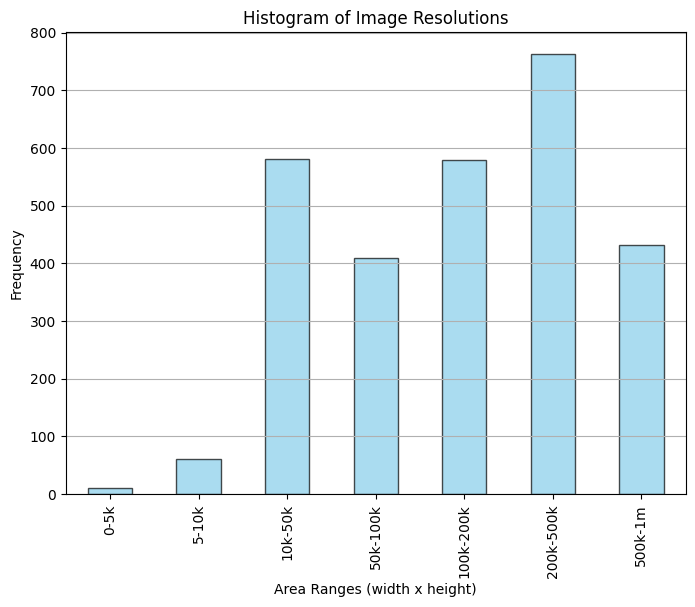

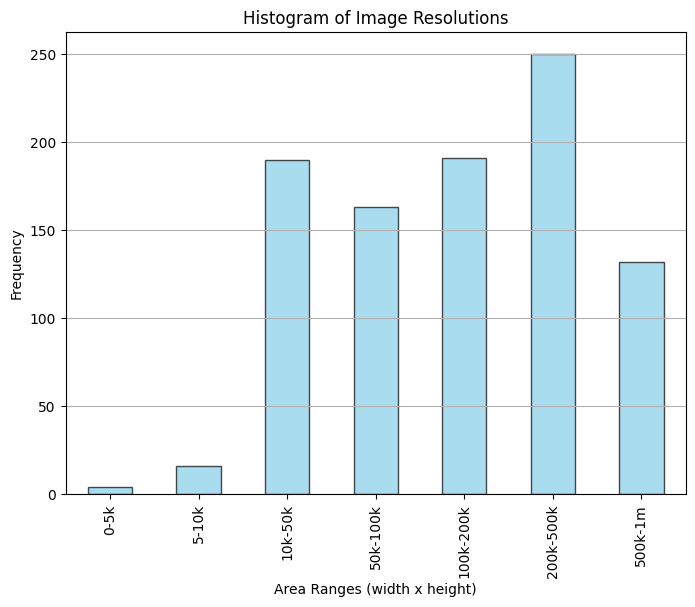

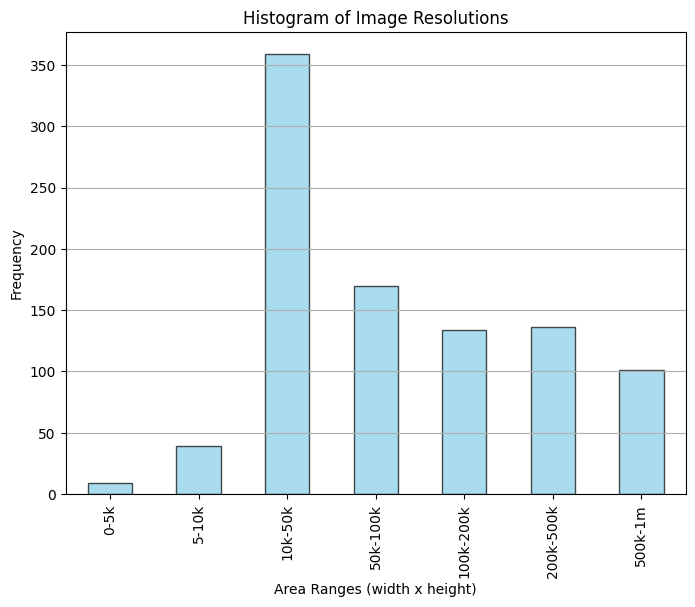

In [11]:
# Create generators for both train and val
batch_size = 1000 # Can use 1200 for val/test and 3400 for train
img_size = (150, 150)

train_gen = stratified_batch_generator(df_train, train_image_dir, batch_size=3000, img_size=img_size)
val_gen = stratified_batch_generator(df_val, val_image_dir, batch_size=batch_size, img_size=img_size)
test_gen =  stratified_batch_generator(df_test, test_image_dir, batch_size=batch_size, img_size=img_size)

# Fetch one batch for train and val
train_images, train_labels, train_original_res = next(train_gen)
val_images, val_labels, val_original_res = next(val_gen)
test_images, test_labels, test_original_res = next(test_gen)

In [12]:
train_size = train_labels.shape[0]
class_1_size = np.sum(train_labels==1)
class_0_size = np.sum(train_labels==0)
print("Train dataset info:")
print(f"class 0 size: {class_0_size} / class 1 size: {class_1_size}")
print(f"{class_1_size / train_size * 100:.4f}% class 1 ")
print("="*40)
val_size = val_labels.shape[0]
class_1_size = np.sum(val_labels==1)
class_0_size = np.sum(val_labels==0)
print("Val dataset info:")
print(f"class 0 size: {class_0_size} / class 1 size: {class_1_size}")
print(f"{class_1_size / val_size * 100:.4f}% class 1 ")
print("="*40)
test_size = test_labels.shape[0]
class_1_size = np.sum(test_labels==1)
class_0_size = np.sum(test_labels==0)
print("Test dataset info:")
print(f"class 0 size: {class_0_size} / class 1 size: {class_1_size}")
print(f"{class_1_size / val_size * 100}% split ")
print("="*40)

Train dataset info:
class 0 size: 1500 / class 1 size: 1500
50.0000% class 1 
Val dataset info:
class 0 size: 500 / class 1 size: 500
50.0000% class 1 
Test dataset info:
class 0 size: 500 / class 1 size: 500
50.0% split 


(3000, 150, 150) uint8


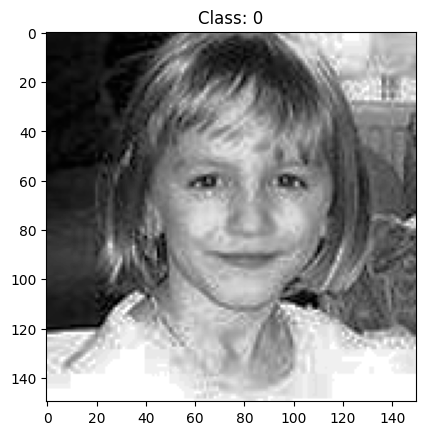

255


In [13]:
# Checkshape and dtype of batch
ix = 0
print(train_images.shape, train_images.dtype)
plt.imshow(train_images[ix], cmap='gray')
plt.title(f"Class: {train_labels[ix]}")
plt.show()
print(np.max(train_images[ix]))

# Feature Extraction

In [14]:
def extract_features(images_batch, feature):
    # Input: images_batch a (batch_size, 150, 150) numpy array containing one batch of images
    # Returns: X a matrix containing the feature vector specified for each image
    features = []
    
    lbp_radius = 3
    lbp_num_points = 6 * lbp_radius
    method='uniform'
    block_size = 50 
    
    hog_orientations=6
    hog_pixels_per_cell=(24, 24)
    hog_cells_per_block=(1, 1)

    for img in images_batch:

        if feature =='lbp':
            # Extract LBP
            # lbp = local_binary_pattern(img, lbp_num_points, lbp_radius, method=method).ravel()
            # features.append(lbp)

            # Rather than simply extract the LBP feature, split the image into blocks
            # For images of size 150x150, we use blocks of size 50 => 3x3 = 9 total sections
            # Compute the lbp for each block of the image and store the information in a histogram
            # Each histogram has lbp_num_points + 2, which is 16 + 2 = 18) bins
            # The first 16 bins are for uniform binary patterns
            # The 17th bin is for non uniform patterns (18th is to avoid not having a bin for non uniform patterns)
            # The histograms are normalised to make each a probability distribution which says the proportion of LBP patterns in each block
            
            lbp_histograms = []
            img = (img * 255).astype(np.uint8)
            for i in range(0, img.shape[0], block_size):
                for j in range(0, img.shape[1], block_size):
                    block = img[i:i+block_size, j:j+block_size]
                    lbp = local_binary_pattern(block, lbp_num_points, lbp_radius, method=method)
                    # Calculate histogram for this block
                    lbp_histogram, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp_num_points+3), range=(0, lbp_num_points+2))

                    lbp_histogram = lbp_histogram.astype("float")
                    lbp_histogram /= (lbp_histogram.sum() + 1e-7) 

                    
                    lbp_histograms.append(lbp_histogram)
            
            features.append(np.concatenate(lbp_histograms))
            
        if feature == 'hog':
            # Extract Histogram of Oriented Gradients
            hog_feature_vec = hog(
                                img,
                                orientations=hog_orientations,
                                pixels_per_cell=hog_pixels_per_cell,
                                cells_per_block=hog_cells_per_block,
                                feature_vector=True,
                                block_norm='L2-Hys'
                                )
            
            features.append(hog_feature_vec)
    X = np.array(features)
    return X

In [29]:
# Obtain X_train a (batch_size, feature_vector_size) matrix containing the feature vectors for each train image
# And y_train is just the class of each image (0 for under 25 / 1 for over 25)
feature_type = 'hog'

X_train = extract_features(train_images, feature = feature_type)
y_train = train_labels
print(X_train.shape, y_train.shape)

# Same for X_val and y_val
X_val = extract_features(val_images, feature = feature_type)
y_val = val_labels
print(X_val.shape, y_val.shape)

# Same for X_test and y_test
X_test = extract_features(test_images, feature = feature_type)
y_test = test_labels
print(X_test.shape, y_test.shape)

(3000, 216) (3000,)
(1000, 216) (1000,)
(1000, 216) (1000,)


In [30]:
# from sklearn.preprocessing import StandardScaler

# # Initialize the scaler
# scaler = StandardScaler()

# # Fit the scaler on the training data and transform it
# X_train = scaler.fit_transform(X_train)

# # Transform the validation and test data using the same scaler
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

In [31]:
# print(np.min(X_train), np.max(X_train), np.mean(X_train))
# print(X_train[0])

# Fit the model to the data
Now that we have a feature vector X and the associated classes y, we can fit the SVM to create a hyperplane between the data

In [32]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn import svm
import numpy as np

param_dist = {
    'C': np.logspace(-3, 3, 100),  # Logarithmic scale for C
    'gamma': np.logspace(-4, 1, 100),  # Logarithmic scale for gamma
    'kernel': ['rbf']  # Keeping the kernel fixed
}

# Create a support vector classifier
svc = svm.SVC(probability=True, class_weight='balanced')

# Stratified K-Fold
cv = StratifiedKFold(n_splits=5)

# Create a model using RandomizedSearchCV
model = RandomizedSearchCV(
    svc, 
    param_dist, 
    n_iter=50,  # Number of random parameter combinations to try
    cv=cv, 
    scoring='accuracy', 
    verbose=1,  # Optional: for detailed output during fitting
    n_jobs=-1  # Use all available processors
)


In [33]:
# from sklearn.model_selection import StratifiedKFold

# param_grid = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#     'gamma': [0.001, 0.01, 0.1, 1, 10],
#     'kernel': ['rbf']
# }


# # Create a support vector classifier
# svc = svm.SVC(probability=True , class_weight='balanced') 

# cv = StratifiedKFold(n_splits=5)

# # Create a model using GridSearchCV with the parameter grid
# model = GridSearchCV(svc, param_grid, cv=cv, scoring='accuracy', verbose=2)

In [34]:
# Train the model using the training data 
model.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=SVC(class_weight='balanced', probability=True),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726...
       6.89261210e-01, 7.74263683e-01, 8.69749003e-01, 9.77009957e-01,
       1.09749877e+00, 1.23284674e+00, 1.38488637e+00, 1.55567614e+00,
       1.74752840e+00, 1.96304065e+00, 2.20513074e+00, 2.47707636e+00,
       2.78255940e+00, 3.12571585e+00, 3.51119173e+00, 3.94420606e+00,
       4.43062146e+00, 4.97702356e+00, 5.59081018e+00, 6.28029144e+00,
       7.05480231e+00, 7.92482898e+00, 8.90215085e+00, 1.00000000e+01]),
                                        'kernel': ['rbf']},
                   scoring='accuracy', verbose=1)

In [38]:
# Calculate validation accuracy
y_val_pred = model.best_estimator_.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Calculate validation loss
y_val_proba = model.best_estimator_.predict_proba(X_val)
val_loss = log_loss(y_val, y_val_proba)

print(f"Validation accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation loss: {val_loss:.4f}")

Validation accuracy: 57.10%
Validation loss: 0.6798


# Histograms of Classification Accuracies by Resolutions

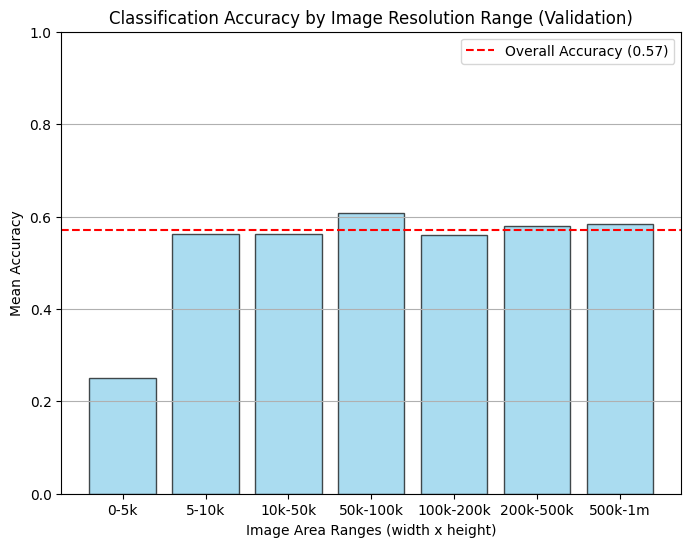

In [39]:
# Define resolution bins and labels
bins = [0,5_000, 10_000, 50_000, 100_000, 200_000, 500_000, 1_000_000]
labels = ['0-5k', '5-10k', '10k-50k', '50k-100k', '100k-200k', '200k-500k', '500k-1m']

# Group images by resolution ranges
resolution_ranges = pd.cut(val_original_res, bins=bins, labels=labels, include_lowest=True)

# Compute accuracy for each range
range_accuracies = {}
for range_label in labels:
    indices = [i for i, r in enumerate(resolution_ranges) if r == range_label]
    if indices:  # Ensure there are samples in the range
        correct = sum(y_val_pred[i] == val_labels[i] for i in indices)
        accuracy = correct / len(indices)
        range_accuracies[range_label] = accuracy
    else:
        range_accuracies[range_label] = None  # No data in this range

# Visualize accuracy by resolution range
plt.figure(figsize=(8, 6))
plt.bar(range_accuracies.keys(), [v if v is not None else 0 for v in range_accuracies.values()],
        color='skyblue', edgecolor='black', alpha=0.7)
plt.axhline(y = val_accuracy, color='red', linestyle='--', label=f'Overall Accuracy ({val_accuracy:.2f})')
plt.title("Classification Accuracy by Image Resolution Range (Validation)")
plt.xlabel("Image Area Ranges (width x height)")
plt.ylabel("Mean Accuracy")
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

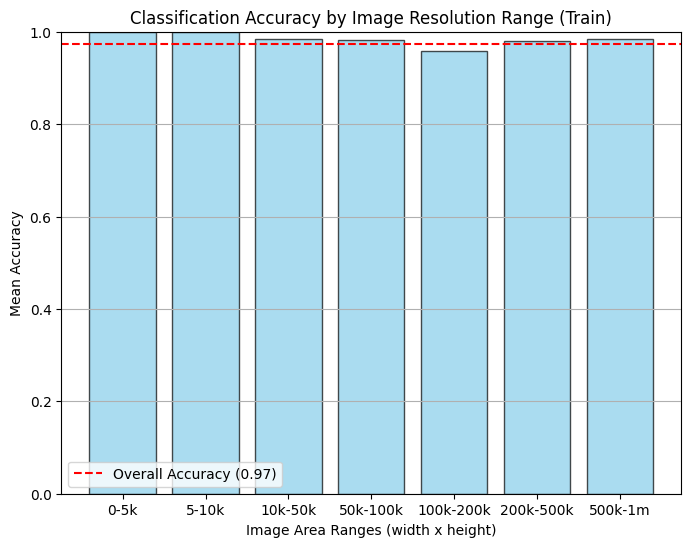

In [40]:
# Define resolution bins and labels
bins = [0,5_000, 10_000, 50_000, 100_000, 200_000, 500_000, 1_000_000]
labels = ['0-5k', '5-10k', '10k-50k', '50k-100k', '100k-200k', '200k-500k', '500k-1m']

# Group images by resolution ranges
resolution_ranges = pd.cut(val_original_res, bins=bins, labels=labels, include_lowest=True)

y_train_pred = model.best_estimator_.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Compute accuracy for each range
range_accuracies = {}
for range_label in labels:
    indices = [i for i, r in enumerate(resolution_ranges) if r == range_label]
    if indices:  # Ensure there are samples in the range
        correct = sum(y_train_pred[i] == train_labels[i] for i in indices)
        accuracy = correct / len(indices)
        range_accuracies[range_label] = accuracy
    else:
        range_accuracies[range_label] = None  # No data in this range

# Visualize accuracy by resolution range
plt.figure(figsize=(8, 6))
plt.bar(range_accuracies.keys(), [v if v is not None else 0 for v in range_accuracies.values()],
        color='skyblue', edgecolor='black', alpha=0.7)
plt.axhline(y = train_accuracy, color='red', linestyle='--', label=f'Overall Accuracy ({train_accuracy:.2f})')
plt.title("Classification Accuracy by Image Resolution Range (Train)")
plt.xlabel("Image Area Ranges (width x height)")
plt.ylabel("Mean Accuracy")
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

65.25% with:
    
    lbp_radius = 3
    lbp_num_points = 8 * lbp_radius
    method='uniform'
    block_size = 75 

65.67% with:

    lbp_radius = 3
    lbp_num_points = 6 * lbp_radius
    method='uniform'
    block_size = 75 

65.17% with:

    lbp_radius = 2
    lbp_num_points = 6 * lbp_radius
    method='uniform'
    block_size = 75 

65.50% with:

    lbp_radius = 3
    lbp_num_points = 8 * lbp_radius
    method='uniform'
    block_size = 50 

65.92% with:

    lbp_radius = 3
    lbp_num_points = 6 * lbp_radius
    method='uniform'
    block_size = 50 
    
64.58% with:

    lbp_radius = 2
    lbp_num_points = 6 * lbp_radius
    method='uniform'
    block_size = 50 


In [66]:
success = np.where(y_val_pred == val_labels)[0]
fail = np.where(y_val_pred != val_labels)[0]
print(success.shape)
print(fail.shape)

(669,)
(331,)


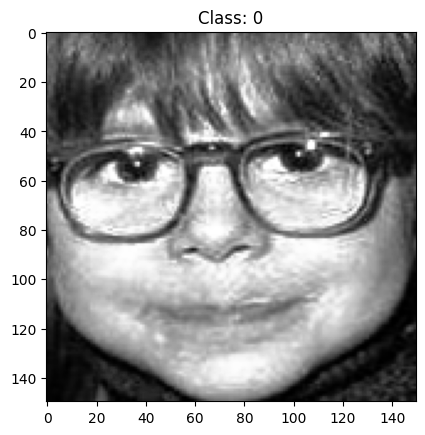

Image 8 is from class 0 and was predicted class 1


In [67]:
i = 0
ix = fail[i]
plt.imshow(val_images[ix], cmap='gray')
plt.title(f"Class: {val_labels[ix]}")
plt.show()
print(f"Image {ix} is from class {val_labels[ix]} and was predicted class {y_val_pred[ix]}")

# Test Performance

In [20]:
# Calculate validation accuracy
y_test_pred = model.best_estimator_.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calculate validation loss
y_test_proba = model.best_estimator_.predict_proba(X_test)
test_loss = log_loss(y_test, y_test_proba)

print(f"Test accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Test accuracy: 65.30%
Test loss: 0.6293


In [21]:
success = np.where(y_test_pred == test_labels)[0]
fail = np.where(y_test_pred != test_labels)[0]
print(success.shape)
print(fail.shape)

(653,)
(347,)


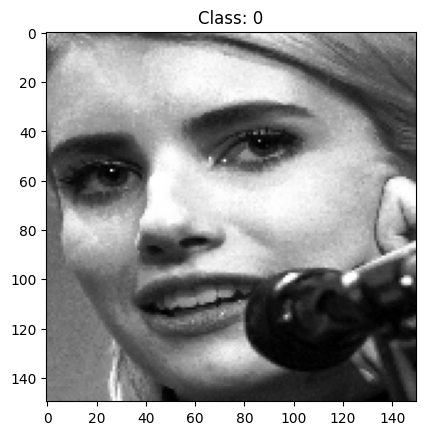

Image 0 is from class 0 and was predicted class 1


In [22]:
i = 0
ix = fail[i]
plt.imshow(test_images[ix], cmap='gray')
plt.title(f"Class: {test_labels[ix]}")
plt.show()
print(f"Image {ix} is from class {test_labels[ix]} and was predicted class {y_test_pred[ix]}")